# Data Analysis of Hostels in Japan

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

According to [japan guide](https://www.japan-guide.com/e/e2025.html), Accomodation prices range from less than 2,000 yen per person in a hostel dormitory to over 50,000 yen per person in a first class hotel or ryokan.

### Questions

- What is the average price per night when budgeting a stay in Japan?
- What can I expect from a hostel given my budget of X JPY? (Regression)

### Preprocessing & Cleaning

We'll start by renaming columns and casting the Distance column from string to numeric type, first removing 'km from city centre' from each entry.

In [35]:
hostel = pd.read_csv('Hostel.csv', index_col=0)
hostel.columns = ["Hostel_Name", "City", "Price_from", 
                      "Distance", "Summary_Score", "Rating", "Atmosphere", 
                      "Cleaniness", "Facilities", "Location", "Security", "Staff", "Value", 
                      "Longitude", "Latitude"]

In [36]:

hostel.groupby('City').count()

,Hostel_Name,Price_from,Distance,Summary_Score,Rating,Atmosphere,Cleaniness,Facilities,Location,Security,Staff,Value,Longitude,Latitude
City,,,,,,,,,,,,,,
Fukuoka-City,19,19,19,17,17,17,17,17,17,17,17,17,14,14
Hiroshima,14,14,14,14,14,14,14,14,14,14,14,14,13,13
Kyoto,78,78,78,73,73,73,73,73,73,73,73,73,66,66
Osaka,104,104,104,101,101,101,101,101,101,101,101,101,89,89
Tokyo,127,127,127,122,122,122,122,122,122,122,122,122,116,116


- Price_from: Min price for 1 night stay (￥）
- Summary_Score: Total rating score of a hostel.
    - Atmosphere: Hostel’s rating score of atmosphere
    - Cleanliness: Hostel’s rating score of cleanliness
    - Facilities: Hostel’s rating score of facilities
    - Location: Hostel’s rating score of location
    - Security: Hostel’s rating score of security
    - Staff: Hostel’s rating score of staff
    - Value: Hostel’s rating score of value for money


In [37]:
hostel["Distance"] = hostel["Distance"].str.split("km").str[0]
hostel.head(1)

,Hostel_Name,City,Price_from,Distance,Summary_Score,Rating,Atmosphere,Cleaniness,Facilities,Location,Security,Staff,Value,Longitude,Latitude
1,"""Bike & Bed"" CharinCo Hostel",Osaka,3300,2.9,9.2,Superb,8.9,9.4,9.3,8.9,9.0,9.4,9.4,135.513767,34.682678


In [38]:
hostel.Distance = pd.to_numeric(hostel.Distance) # Cast Distance to numeric 

We continue by removing the Longitude and Latitude columns in the dataframe, they won't be necessary in answering our question.  
We also remove any rows that contain 5 or more NULL values.

In [39]:
hostel.drop(['Longitude', 'Latitude'], axis=1, inplace=True) # remove latitude, longitude column
hostel.dropna(thresh=5, inplace=True) # remove rows that contain less than 5 values

In [40]:
print('There are %d NULL values in our dataframe' %hostel.isnull().any().sum()) # check if there are any null values
hostel.tail()

There are 0 NULL values in our dataframe


,Hostel_Name,City,Price_from,Distance,Summary_Score,Rating,Atmosphere,Cleaniness,Facilities,Location,Security,Staff,Value
338,YADOYA Guesthouse Green,Tokyo,2300,2.6,8.2,Fabulous,7.9,7.7,6.9,8.9,8.9,8.8,8.3
339,YADOYA Guesthouse Orange,Tokyo,2000,2.9,8.9,Fabulous,8.6,9.0,7.8,9.4,9.0,9.2,9.4
340,YAWP! backpackers,Tokyo,2500,17.5,9.3,Superb,9.5,9.3,9.4,8.5,9.5,9.2,9.6
341,You En Me House,Kyoto,2800,2.4,8.0,Fabulous,7.3,8.0,6.7,8.0,8.7,10.0,7.3
342,Zabutton Hostel,Tokyo,2900,5.9,8.6,Fabulous,8.1,8.5,7.8,9.0,8.9,9.5,8.5


## Exploratory Data Analysis

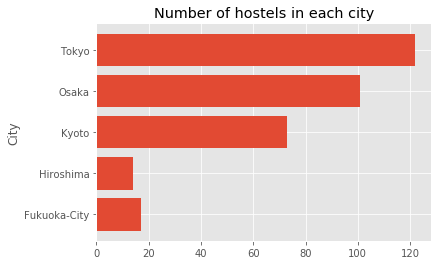

In [41]:
#  number of hostels in each city
hostel.groupby('City').size().plot(kind='barh', width=0.8, title='Number of hostels in each city', )
plt.show()

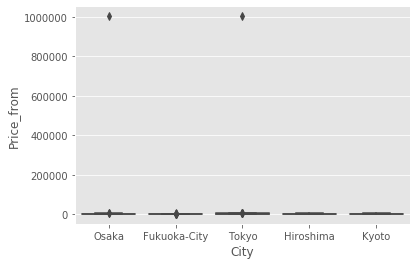

In [42]:
sns.boxplot(hostel.City, hostel['Price_from'])
plt.show()
# two obvious outliers in Tokyo and Osaka

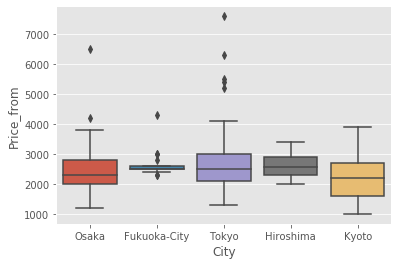

In [43]:
hostel = hostel[hostel["Price_from"] < 10000]
sns.boxplot(hostel.City, hostel['Price_from'])
plt.show()
# It's expected that Tokyo would have a large range of hostel prices considering it is the capital city, most popular

### Location, Location, Location

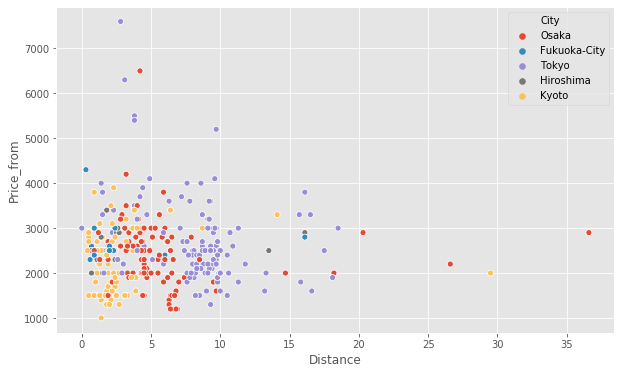

In [44]:
plt.figure(figsize = (10,6))
sns.scatterplot(data=hostel, x=hostel.Distance, y=hostel.Price_from, hue=hostel.City,)
plt.show()

It's surprising to see that distance from the city centre doesn't affect the pricing of Hostels.  
Especially Kyoto, the majority of hostels are located within 5km of its centre.

In [45]:
## Rating bands Rating -> Good -> V. Good -> Fabulous -> Superb
print(hostel.groupby('Rating')['Summary_Score'].max() )
hostel.groupby('Rating')['Summary_Score'].min()

Rating
Fabulous      8.9
Good          6.9
Rating        5.7
Superb       10.0
Very Good     7.9
Name: Summary_Score, dtype: float64


Rating
Fabulous     8.0
Good         6.0
Rating       3.1
Superb       9.0
Very Good    7.0
Name: Summary_Score, dtype: float64

## What Can I expect for X JPY?

### Multilinear Regression Model

In [46]:
from sklearn.linear_model import LinearRegression

Before we fit a model to our dataset we first condsider the underlying assumptions.

We have 3 main categories for our predictors, Distance (from the City centre), Summary Score which is comprised of location, security, atmosphere, cleanliness, facilities and staff and a discrete predictor, the cites.

As we only have a few datapoints for Hiroshima and Fukuoka we'll consider the three major cities Kyoto, Tokyo and Osaka as indicator variables.


In [49]:
# one-hot encode city variable 
hostel = hostel.join(pd.get_dummies(hostel.City))